# VRNN for row-by-row MNIST generation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as d

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['png']

In [3]:
from tqdm import tqdm
import pickle

In [4]:
Normal = d.Normal
Ind = d.Independent
Bern = d.Bernoulli

$$h_t = (x_{1:t-1}, z_{1:t-1})$$

In [5]:
class p_zt_given_ht_class(nn.Module):
    
    def __init__(self, z_dim, h_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(h_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
        )
        self.mu = nn.Linear(500, z_dim)
        self.sigma = nn.Sequential(
            nn.Linear(500, z_dim),
            nn.Softplus()
        )
        
    def forward(self, ht):
        temp = self.shared(ht)
        return Ind(Normal(self.mu(temp), self.sigma(temp)), 1)

In [6]:
class p_xt_given_ht_zt_class(nn.Module):
    
    def __init__(self, x_dim, z_dim, h_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(h_dim + z_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, x_dim),
            nn.Sigmoid()
        )
        
    def forward(self, ht, zt):
        return Ind(Bern(self.layers(torch.cat([ht, zt], dim=1))), 1)

In [7]:
class q_zt_given_ht_xt_class(nn.Module):
    
    def __init__(self, x_dim, z_dim, h_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(h_dim+x_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
        )
        self.mu = nn.Linear(500, z_dim)
        self.sigma = nn.Sequential(
            nn.Linear(500, z_dim),
            nn.Softplus()
        )
        
    def forward(self, ht, xt):
        temp = self.shared(torch.cat([ht, xt], dim=1))
        return Ind(Normal(self.mu(temp), self.sigma(temp)), 1)

In [8]:
class f_class(nn.Module):
    
    def __init__(self, x_dim, z_dim, h_dim):
        super().__init__()
        self.layers = nn.LSTM(
            input_size=x_dim+z_dim,
            hidden_size=h_dim, 
            batch_first=True,
            num_layers=2
        )
        
    def forward(self, xt, zt, state_tminus1):
        return self.layers(torch.cat([xt, zt], dim=1).unsqueeze(1), state_tminus1)

In [9]:
class AEVB(nn.Module):
    
    def __init__(self, x_dim, z_dim, h_dim, lr=1e-3):
        
        super().__init__()
        
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.h_dim = h_dim
        
        # generative model
        self.p_zt_given_ht = p_zt_given_ht_class(z_dim, h_dim)  # MLP
        self.p_xt_given_ht_zt = p_xt_given_ht_zt_class(x_dim, z_dim, h_dim)  # MLP
        
        # approximate posterior
        self.q_zt_given_ht_xt = q_zt_given_ht_xt_class(x_dim, z_dim, h_dim)  # MLP
    
        # recurrent summarizer
        self.f = f_class(x_dim, z_dim, h_dim)  # LSTM
        
        self.opt = optim.Adam(self.parameters(), lr=lr)
    
    def step(self, x, train):
        
        if train:
            self.train()
        else:
            self.eval()
        
        bs = x.size(0)
        seq_len = x.size(1)

        elbo = 0

        for t in range(seq_len):
            
            xt = x[:,t,:]

            if t == 0:
                ht = torch.zeros(bs, self.h_dim)
                state_t = None
            else:
                ht, state_t = self.f(x_tminus1, z_tminus1, state_tminus1)
                ht = ht.squeeze()  # get rid of the "direction" dimension
            
            prior_over_zt = self.p_zt_given_ht(ht)
            posterior_over_zt = self.q_zt_given_ht_xt(ht, xt)

            kl = d.kl.kl_divergence(posterior_over_zt, prior_over_zt)

            zt = posterior_over_zt.sample()

            rec = self.p_xt_given_ht_zt(ht, zt).log_prob(xt)

            elbo += (rec - kl).mean()
            
            # prepare for next timestep
            
            x_tminus1 = xt
            z_tminus1 = zt
            state_tminus1 = state_t
            
            # sanity checks
            gar
            assert kl.size() == (bs, )
            assert zt.size() == (bs, self.z_dim)
            assert rec.size() == (bs, )
            assert ht.size() == (bs, self.h_dim)
            
        loss = -elbo
            
        if train:
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

        return float(elbo)

In [10]:
import numpy as np
from keras.datasets.mnist import load_data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train + np.random.uniform(low=0, high=1, size=x_train.shape)
x_train = x_train / 256

x_test = x_test + np.random.uniform(low=0, high=1, size=x_test.shape)
x_test = x_test / 256

x_train[x_train > 0.5] = 1 
x_train[x_train <= 0.5] = 0

x_test[x_test > 0.5] = 1 
x_test[x_test <= 0.5] = 0

train_ds = TensorDataset(torch.from_numpy(x_train).float())
train_dl = DataLoader(train_ds, batch_size=100)

test_ds = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())
test_dl = DataLoader(test_ds, batch_size=1000, shuffle=False)

x_test_torch = torch.from_numpy(x_test).float()

In [11]:
# aevb.step(x_test_torch[:32], train=True)

## Training

In [12]:
# aevb = AEVB(x_dim=28, z_dim=2, h_dim=256)
# test_elbos = []
# for e in range(10):
#     for xb, in tqdm(train_dl):
#         aevb.step(xb, train=True)
#     test_elbo = aevb.step(x_test_torch, train=False)
#     print(test_elbo)
#     test_elbos.append(test_elbo)

In [13]:
# torch.save(aevb.state_dict(), "vrnn.pth")
# with open("test_elbos", "wb") as fp:
#     pickle.dump(test_elbos, fp)

In [14]:
aevb = AEVB(x_dim=28, z_dim=2, h_dim=256)
aevb.load_state_dict(torch.load("vrnn.pth", map_location=torch.device("cpu")))
with open("test_elbos", "rb") as fp:
     test_elbos = pickle.load(fp)

## Test ELBO

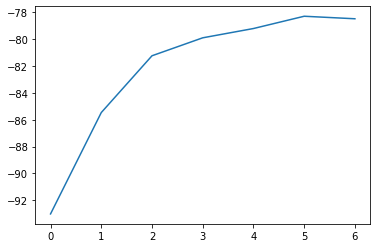

In [15]:
plt.plot(test_elbos)
plt.show()

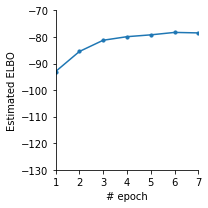

In [16]:
fig = plt.figure(figsize=(3, 3))

plt.plot(range(1, len(test_elbos) + 1), test_elbos)
plt.scatter(range(1, len(test_elbos) + 1), test_elbos, s=10)
plt.xlabel("# epoch")
plt.xlim(1, 7)
plt.xticks(range(1, 8))
plt.ylabel("Estimated ELBO")
plt.ylim(-130, -70)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.tight_layout()
plt.savefig("learning_curves.pdf", bbox_inches='tight', pad_inches = 0)

## Generation

Save them and use another script to create animation

In [17]:
def sample(self, n):
    
    with torch.no_grad():
    
        ht = torch.zeros(n, self.h_dim)
        state_t = None

        rows = []  # there should be seq_len number of tensors with shape (bs, row_width)

        for t in range(28):

            prior_over_zt = self.p_zt_given_ht(ht)
            zt = prior_over_zt.sample()
            xt = self.p_xt_given_ht_zt(ht, zt).sample()
            xt_mean = self.p_xt_given_ht_zt(ht, zt).mean

            rows.append(xt_mean)
            
            ht, state_t = self.f(xt, zt, state_t)
            ht = ht.squeeze()

        return torch.stack(rows, dim=1)

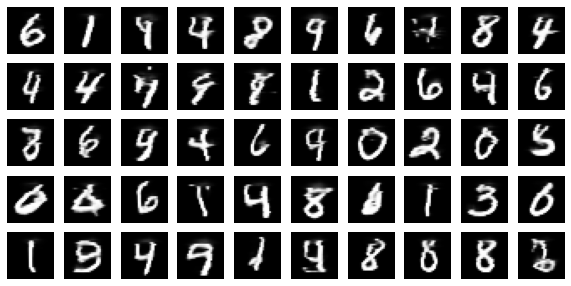

In [18]:
torch.manual_seed(1)
gens = sample(aevb, n=50)
gens = gens.numpy()
plt.figure(figsize=(10, 5))
for i in range(1, 51):
    plt.subplot(5, 10, i)
    plt.imshow(gens[i-1].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.savefig("mnist_gens_mean.pdf", bbox_inches='tight',pad_inches = 0)

In [19]:
def create_animation_array(gens):
    mask = np.zeros((gens.shape[0], 28, 28, 28))
    for i in range(28):
        mask[:,i,:i,:] = 1
    return mask * gens.reshape(gens.shape[0], 1, 28, 28)

In [20]:
np.save("mnist_gens_mean.npy", create_animation_array(gens))

# TSNE

In [27]:
def encode(self, x):
    
    with torch.no_grad():
    
        ht = torch.zeros(x.size(0), self.h_dim)
        state_t = None

        zt_s = []  # there should be seq_len number of tensors with shape (bs, 2)

        for t in range(28):

            xt = x[:,t,:]

            posterior_over_zt = self.q_zt_given_ht_xt(ht, xt)

            zt = posterior_over_zt.sample()
            
            zt_s.append(posterior_over_zt.mean)

            ht, state_t = self.f(xt, zt, state_t)
            ht = ht.squeeze()  # get rid of the "direction" dimension
            
        return torch.cat(zt_s, dim=1)

In [28]:
latent_vecs = encode(aevb, x_test_torch)

In [29]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [30]:
tsne_results = PCA().fit_transform(latent_vecs)

In [31]:
tsne_results = TSNE(learning_rate="auto", init="pca").fit_transform(latent_vecs)

/Users/zhihanyang/opt/miniconda3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


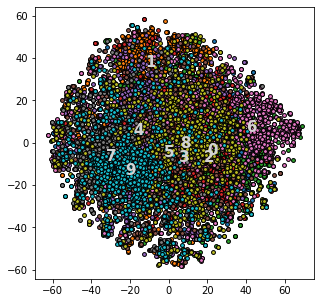

In [32]:
plt.figure(figsize=(5, 5))
for g in np.unique(y_test):
    i = np.where(y_test == g)
    plt.scatter(tsne_results[:, 0][i], tsne_results[:, 1][i], s=15, edgecolor='black')
    median_x = np.median(tsne_results[:, 0][i])
    median_y = np.median(tsne_results[:, 1][i])
    plt.annotate(g, xy=(median_x, median_y), xytext=(-5, -5), textcoords="offset points",
                 color="lightgray", fontsize=15, weight="bold")
plt.savefig("tsne.pdf", bbox_inches='tight',pad_inches = 0)